# System dynamics when both the weights and activity evolve

Using Oja's rule the weights should always converge to have an L2 norm of 1, which we modify with the $\lambda$ coefficient so the L2 norm is $\frac{2}{N}$ (ie. the Fourier coefficient is 1)

Our derivation involved integrating over a period of rotating activity before making a weight update, so we sum weight updates over each period before just applying the weight update at the end. If we make the weights dynamic during each timestep of the period, things don't work out so nicely. In general we can just argue that the dynamics of the weights is much slower than the dynamics of the activity

We could only prove local stability to perturbations, so start with ideal weights and activity, perturb the weights, and see how the system evolves. The activity might gain/lose some magnitude but the weights should return to the correct distribution.

In [2]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

C:\Users\Dominic\AppData\Local\Temp\ipykernel_22864\1923318813.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [3]:
N = 8
neuron_indices = np.arange(N)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_modes = lambda fourier_modes: np.fft.ifft(np.hstack((fourier_modes, np.flip(fourier_modes[1:-1])))).real

v_magnitude = .25
a = v_magnitude * (np.cos(2*np.pi*neuron_indices/N)) # a = ||v|| * F^-1{[1,1/2,0,...]}
_lambda = N/2

input = profile_to_matrix(a)

In [5]:
def simulate_and_plot_fixed_activity(a, eta=0.01, plot=True, show=True):
	N = a.shape[1]
	W = np.zeros((N,N))

	delta_W_trace = []
	W_trace = []

	for t in range(a.shape[0]):
		delta_W = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*a[t,:].reshape(1,N)**2*W
		W += eta*delta_W
		delta_W_trace.append(delta_W.copy())
		W_trace.append(W.copy())

	if plot:
		plt.pcolor(W)
		plt.colorbar()
		if show:
			plt.show()
		plt.figure()
		plot_circulant_matrix_as_profile(W, show=show)

	return W, delta_W_trace, W_trace

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0])
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, mu)
	if plot_stddev:
		plt.fill_between(N, mu-stddev, mu+stddev, alpha=0.2)
	if show:
		plt.show()

## functions for generating phase portrait
def profile_to_mu_amp_phase(profile):
	return profile.mean(), (profile.max()-profile.min())/2, np.argmax(profile)

def grad_over_period(W, a):
	grad_W = np.zeros_like(W)
	for t in range(a.shape[0]):
		grad_W += a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*a[t,:].reshape(1,N)**2*W
	return grad_W

def get_grad_over_period(mu, amp, eta=0.001):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_over_period(W, input))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

def grad_over_period_dynamic(W, a0, eta):
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	for t in range(W.shape[0]):
		grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a[t,:].reshape(1,N)**2*W
		grad_a = W@a - a
		a += eta*grad_a
		W += eta*grad_W
		grad_W_accumulated += grad_W
	return grad_W_accumulated

def get_grad_over_period_dynamic(mu, amp, eta=0.001):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_over_period_dynamic(W, input[0], eta))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

def grads_over_period(W, a, eta=0.001):
	W = W.copy()
	grad_W = np.zeros((a.shape[0], *W.shape))
	for t in range(a.shape[0]):
		grad_W[t] = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*a[t,:].reshape(1,N)**2*W
		W += eta*grad_W[t]
	return grad_W

def get_grads_over_period(mu, amp):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	return np.array([profile_to_mu_amp_phase(get_circulant_matrix_profile(grad)[0]) for grad in grads_over_period(W, input)])

C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in multiply
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in matmul
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in square
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: invalid value encountered in subtract
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W


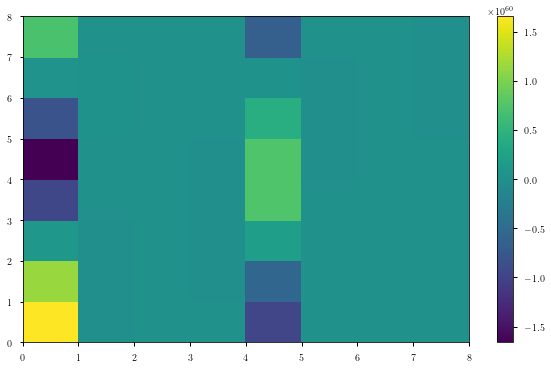

Weight Errors: RMS before = 0.525, RMS after = 432102135369731430069786292689504565643870412412086841769984.000


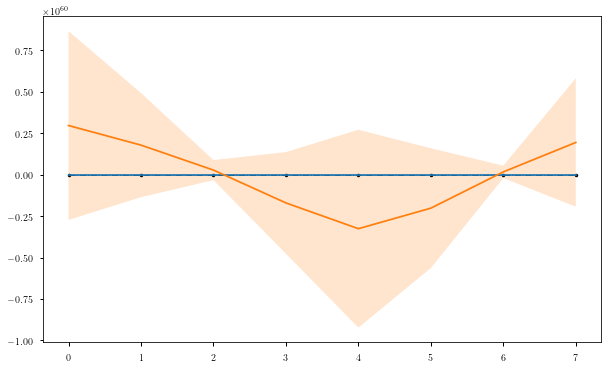

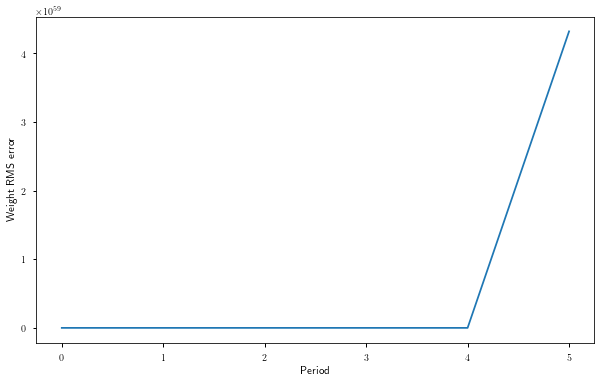

C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:54: RuntimeWarning: overflow encountered in square
  print(f'Activity Error: RMS after = {np.sqrt(np.mean((a0 - a)**2)):.2f}')


Activity Error: RMS after = inf


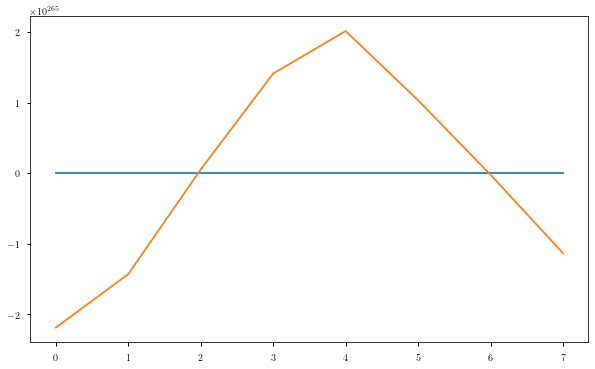

In [5]:
def W_a_after_period_dynamic(W, W0, a0, input, eta):
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	a_trace = []
	W_rms_trace = []
	for t in range(input.shape[0]):
		grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
		grad_a = W@a - a + input[t,:]
		a += eta*grad_a
		grad_W_accumulated += grad_W
		if np.any(np.isnan(grad_W)) or np.any(np.isnan(grad_a)):
			break
		if t % N == 0:
			W += eta*grad_W_accumulated
			grad_W_accumulated = 0
			W_rms_trace.append(np.sqrt(np.mean((W0 - W)**2)))
		a_trace.append(a.copy())
	return W, a, a_trace, W_rms_trace

eta=0.01
f=1
W0_clean = 2/N * profile_to_matrix(np.cos(2*f*np.pi*neuron_indices/N))
noise_sigma = 0.1
W0 = 4*W0_clean + noise_sigma*np.random.randn(N,N)
a0 = 6*np.cos(2*f*np.pi*neuron_indices/N)

theta_input = np.arange(N) / f
periods = 10
# can derive this by np.cos(2*f*np.pi*neuron_indices/N - 2*np.pi/N) - np.cos(2*f*np.pi*neuron_indices/N - 2*np.pi/N)
# get sqrt(2 - 2cos(pi/4)) * cos(2*pi*f*n/N - 5*pi/N)
better_input = 1/eta* np.sqrt(2 - np.sqrt(2)) * np.tile(np.cos(2*f*np.pi*neuron_indices.reshape(N,1)/N - 2*f*np.pi*theta_input.reshape(1,N)/N - 5*np.pi/N).T, (periods,1))

W, a, a_trace, W_rms_trace = W_a_after_period_dynamic(W0.copy(), W0_clean, a0.copy(), better_input, eta)

plt.pcolor(W)
plt.colorbar()
plt.show()
# plot_circulant_matrix_as_profile(W0_clean, show=False)
plt.plot(2/N*np.cos(2*f*np.pi*neuron_indices/N), 'k.-.', linewidth=1)
plot_circulant_matrix_as_profile(W0, show=False)
plot_circulant_matrix_as_profile(W, show=False)
print(f'Weight Errors: RMS before = {np.sqrt(np.mean((W0 - W0_clean)**2)):.3f}, RMS after = {np.sqrt(np.mean((W - W0_clean)**2)):.3f}')
plt.show()

plt.plot(W_rms_trace)
plt.xlabel('Period')
plt.ylabel('Weight RMS error')
# plt.ylim(0, noise_sigma)
plt.show()

plt.figure()
plt.plot(a0)
plt.plot(a)
print(f'Activity Error: RMS after = {np.sqrt(np.mean((a0 - a)**2)):.2f}')
plt.show()

Basically there seem to be 2 "stable" cases
* things return back to the stable weights and activity values and the activity keeps rolling around the ring
* the bump "stops" and the weight matrix explodes with positive connections in one spot and negative in the other

Maybe we could track the bump velocity somehow, though it's hard when there are multiple bumps around the ring at once

## What if we compare the convergence rate for different harmonics?

Doesn't seem to be a big difference between the failure rate with different harmonics. The different possible failures are:
* the bump stops rotating and the weights where the bump are explode
* the weight profile flips because the weight amplitude is higher than it should be, and the activity is so high that the weight profile change over one period is bigger than the weight profile itself. It jumps to a flipped version and breaks everything

Below we prove the second doesn't change with respect to harmonic. The first still to do...

C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in matmul
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in square
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: invalid value encountered in subtract
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:16: RuntimeWarning: overflow encountered in square
  W_rms_trace.append(np.sqrt(np.mean((W0 - W)**2)))
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:7: RuntimeWarning: overflow encountered in multiply
  grad_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
C:\Users\Dominic\AppData\Local\Temp\ipykernel_12028\2384228651.py:

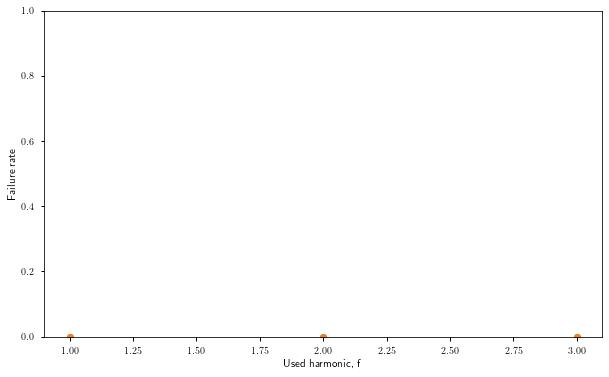

In [6]:
noise_sigma = 10
periods = 100
a0_ratio = 2
eta=0.01

f_range = np.arange(1,4)
failure_rates = []
failure_rates_scaled = []

for f in range(1,4):
	W0_clean = 2/N * profile_to_matrix(np.cos(2*f*np.pi*neuron_indices/N))
	a0 = a0_ratio*np.cos(2*f*np.pi*neuron_indices/N)
	theta_input = np.arange(N) / f
	better_input = 1/eta* np.sqrt(2 - np.sqrt(2)) * np.tile(np.cos(2*f*np.pi*neuron_indices.reshape(N,1)/N - 2*f*np.pi*theta_input.reshape(1,N)/N - 5*np.pi/N).T, (periods,1))

	failure_rates.append(np.mean([
		np.isnan(W_a_after_period_dynamic(W0_clean + noise_sigma*np.random.randn(N,N), W0_clean, a0.copy() + 0.5*np.random.randn(N), better_input, eta)[3][-1])
		for _ in range(100)
	]))

	better_input = 1/eta*a0_ratio*np.sqrt(2 - np.sqrt(2)) * np.tile(np.cos(2*f*np.pi*neuron_indices.reshape(N,1)/N - 2*f*np.pi*theta_input.reshape(1,N)/N - 5*np.pi/N).T, (periods,1))

	failure_rates_scaled.append(np.mean([
		np.isnan(W_a_after_period_dynamic(W0_clean + noise_sigma*np.random.randn(N,N), W0_clean, a0.copy() + 0.5*np.random.randn(N), better_input, eta)[3][-1])
		for _ in range(100)
	]))

plt.plot(f_range, failure_rates, 'o')
plt.plot(f_range, failure_rates_scaled, 'o')
plt.xlabel('Used harmonic, f')
plt.ylabel('Failure rate')
plt.ylim(0,1)
plt.show()

### Building a phase portrait of the system

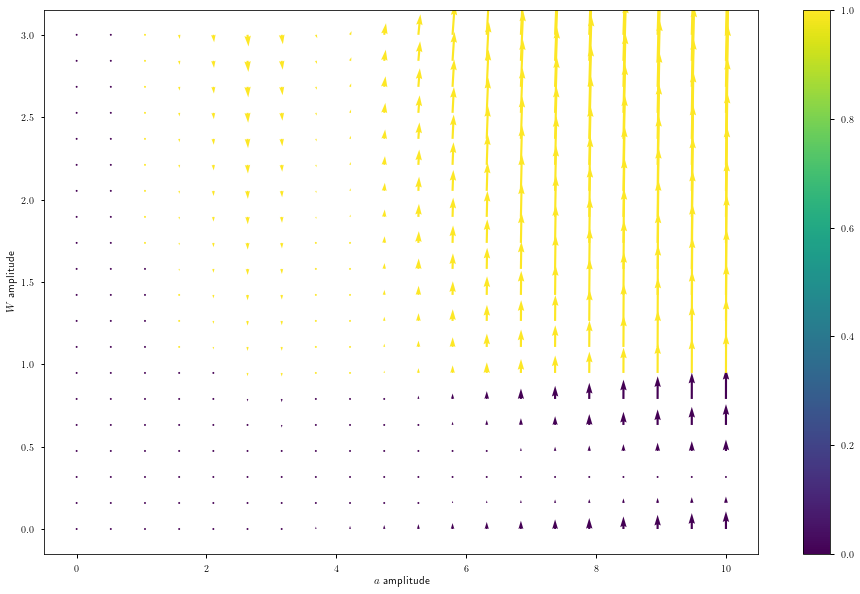

In [7]:
a_amp_range = np.linspace(0,10,20)
W_amp_range = np.linspace(0,3,20)
a_amp_values, W_amp_values = np.meshgrid(a_amp_range, W_amp_range)

a_amp_grads = np.zeros((len(a_amp_range), len(W_amp_range)))
W_amp_grads = np.zeros((len(a_amp_range), len(W_amp_range)))
W_amp_phases = np.zeros((len(a_amp_range), len(W_amp_range)))

def grad_over_period_dynamic(W, a0, input, eta):
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	for t in range(input.shape[0]):
		grad_W = eta * (a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W)
		grad_a = eta * (W@a - a + input[t])
		a += grad_a
		# W += grad_W
		grad_W_accumulated += grad_W
	return grad_W_accumulated, a - a0

def get_grad_over_period_dynamic(a_amp, W_amp, f, vis=False):
	W = profile_to_matrix(W_amp*np.cos(2*f*np.pi*neuron_indices/N))
	a0 = a_amp*np.cos(2*f*np.pi*neuron_indices/N)
	theta_input = np.arange(N) / f
	input = 1/eta* a_amp*np.sqrt(2 - np.sqrt(2)) * np.cos(2*f*np.pi*neuron_indices.reshape(N,1)/N - 2*f*np.pi*theta_input.reshape(1,N)/N - 5*np.pi/N).T
	# W_mu_before, W_amp_before, W_phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	W_grad, a_grad = grad_over_period_dynamic(W, a0, input, eta)
	W_mu_after, W_amp_after, W_phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W + W_grad)[0])
	a_mu_after, a_amp_after, a_phase_after = profile_to_mu_amp_phase(a0 + a_grad)
	if vis:
		plt.plot(get_circulant_matrix_profile(W)[0])
		plt.plot(get_circulant_matrix_profile(W + W_grad)[0])
		plt.title(f'W_amp before = {W_amp}, after = {W_amp_after:.3f}, $\\Delta$={W_amp_after - W_amp:.3f}, phase={W_phase_after:.3f}')
		plt.show()
	return a_amp_after - a_amp, W_amp_after - W_amp, W_phase_after

# todo: can we colour the quivers based on the phase?

for i,a_amp in enumerate(a_amp_range):
	for j,W_amp in enumerate(W_amp_range):
		a_amp_grad, W_amp_grad, W_amp_phase = get_grad_over_period_dynamic(a_amp, W_amp, f=1)
		a_amp_grads[i,j] = a_amp_grad
		W_amp_grads[i,j] = W_amp_grad
		W_amp_phases[i,j] = W_amp_phase


plt.figure(figsize=(16,10))
plt.quiver(a_amp_range, W_amp_range, a_amp_grads.T, W_amp_grads.T, W_amp_phases > 0)
plt.xlabel('$a$ amplitude')
plt.ylabel('$W$ amplitude')
plt.colorbar()
plt.show()

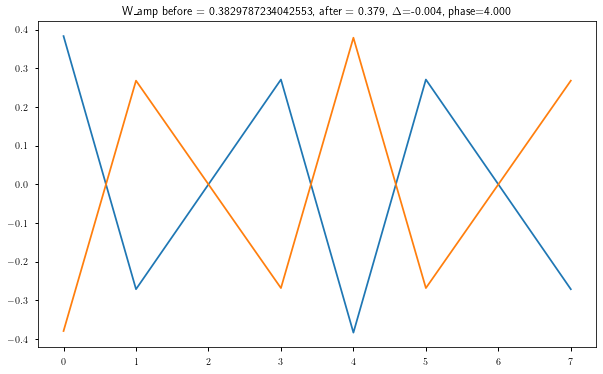

(0.0007006207308117851, -0.004125865679329377, 4)

In [8]:
a_amp = 6
W_amp_flip = 2/N / (1 - 4/(eta*a_amp**2*N**2))
W_amp_flip_increase = 2/N / (1 - 8/(eta*a_amp**2*N**2))

get_grad_over_period_dynamic(a_amp=a_amp, W_amp=W_amp_flip_increase, f=3, vis=True)


# todo:
# what does the weight matrix look like after the profile flips?
# Each neuron inhibits its neighbours and excites neurons far away?

In [176]:
a_amp = 2
W_amp = 1/4
f=1
periods = 1

epsilon_W = -.1

W0 = profile_to_matrix(W_amp*np.cos(2*f*np.pi*neuron_indices/N))
W = W0.copy()
W[0,0] += epsilon_W
a0 = a_amp*np.cos(2*f*np.pi*neuron_indices/N)
a = a0.copy()
theta_input = np.arange(N) / f
input = 1/eta* a_amp*np.sqrt(2 - np.sqrt(2)) * np.tile(np.cos(2*f*np.pi*neuron_indices.reshape(N,1)/N - 2*f*np.pi*theta_input.reshape(1,N)/N - 5*np.pi/N).T, (periods,1))

grad_W_accumulated = np.zeros_like(W)
grad_W0_accumulated = np.zeros_like(W)
a_trace = []
grad_W_trace = []

for t in range(1):#range(input.shape[0]):
	grad_W = eta * (a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W)
	grad_W0 = eta * (a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W0)
	# grad_a = eta * (W@a - a + input[t])
	# a += grad_a
	# W += grad_W
	# a_trace.append(a.copy())
	# grad_W_trace.append(grad_W.copy())
	grad_W_accumulated += grad_W
	grad_W0_accumulated += grad_W0
a_trace = np.array(a_trace)
grad_W_trace = np.array(grad_W_trace)

There's a difference in which weights are affected by a perturbation to one weight, depending on the harmonic. But *only* if we do weight updates at each step, not just over a period. Somehow this is mainly visible when the perturbation is small, otherwise the "reactive" change in the perturbed weight overshadows the downstream changes

It's unclear what the results of this are though...

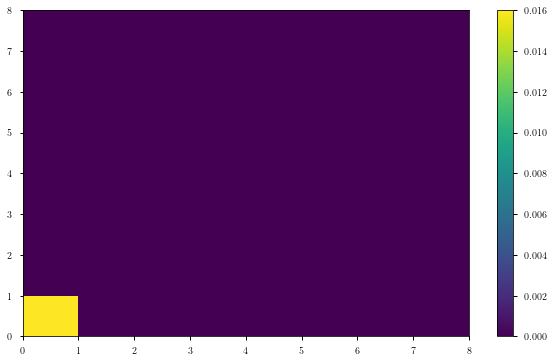

In [177]:
plt.pcolor(grad_W_accumulated - grad_W0_accumulated)
plt.colorbar()
plt.show()

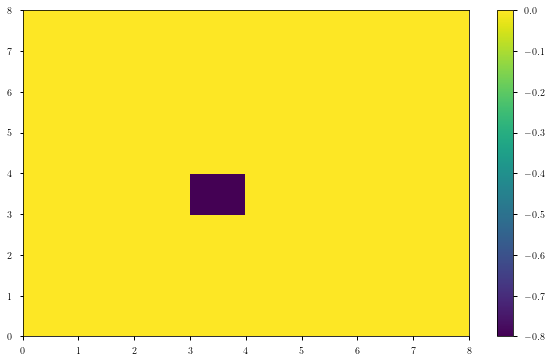

In [157]:
dA0 = eta * (W0@a - a + input[0])
dA = eta * (W@a - a + input[0])
g0 = (a+dA0).reshape(N,1) @ (a+dA0).reshape(1,N) -_lambda*(a+dA0).reshape(1,N)**2*W0
g1 = (a+dA).reshape(N,1) @ (a+dA).reshape(1,N) -_lambda*(a+dA).reshape(1,N)**2*W
plt.pcolor(g1-g0)
plt.colorbar()
plt.show()

c:\ProgramData\Miniconda3\envs\insects\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


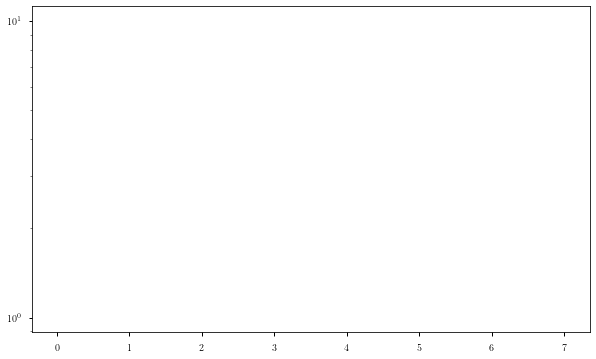

In [158]:
plt.semilogy((g0-g1)[0,:])
plt.semilogy((g0-g1)[:,0])

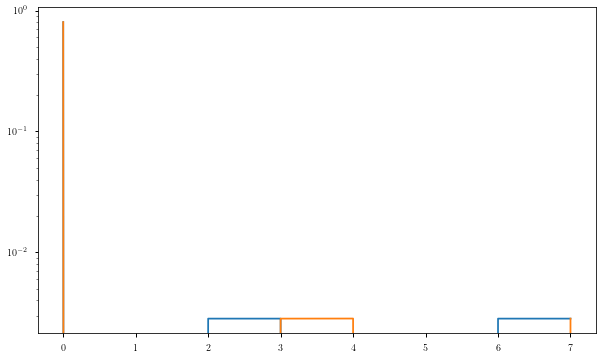

In [135]:
plt.semilogy((g0-g1)[0,:])
plt.semilogy((g0-g1)[:,0])

In [132]:
g0 - g1

array([[ 8.02264342e-01, -4.00000000e-03, -2.82842712e-03,
        -4.44089210e-19,  2.82842712e-03,  4.00000000e-03,
         2.82842712e-03,  8.88178420e-19],
       [ 2.82842712e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.82842712e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.00282843e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.83242712e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.82842712e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.82842712e-03,  0.000000

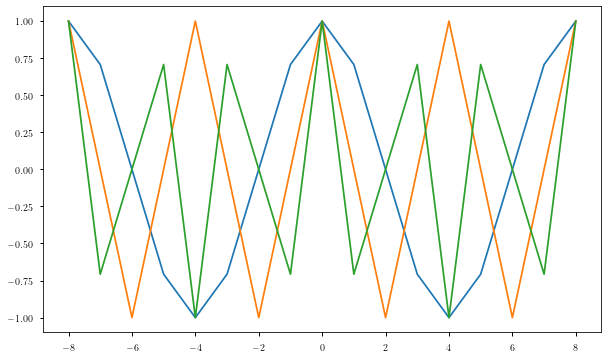

In [141]:
dN = np.arange(-N,N+1)
plt.plot(dN, np.cos(2*np.pi*dN/N))
plt.plot(dN, np.cos(2*2*np.pi*dN/N))
plt.plot(dN, np.cos(2*3*np.pi*dN/N))

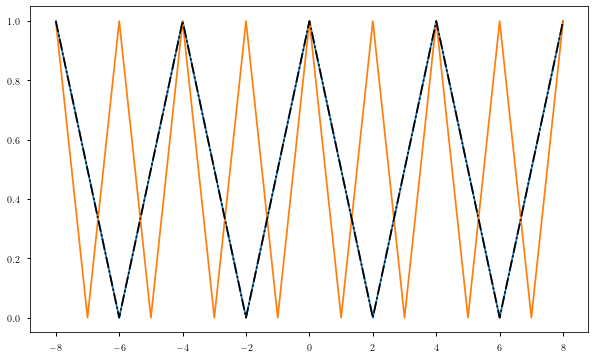

In [154]:
dN = np.arange(-N,N+1)
plt.plot(dN, np.cos(2*np.pi*dN/N)**2)
plt.plot(dN, np.cos(2*2*np.pi*dN/N)**2)
plt.plot(dN, np.cos(2*3*np.pi*dN/N)**2, 'k-.')

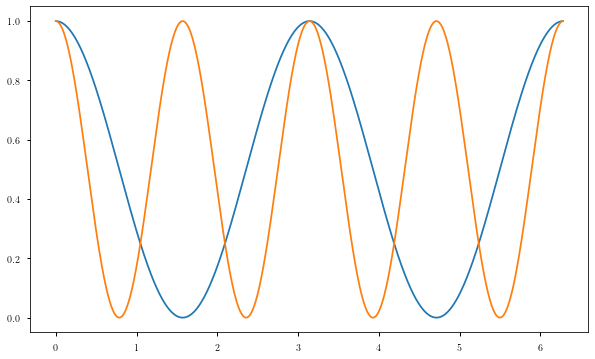

In [147]:
x = np.arange(0,2,0.001)
plt.plot(x*np.pi, np.cos(x*np.pi)**2)
plt.plot(x*np.pi, np.cos(2*x*np.pi)**2)

In [148]:
k = np.arange(10)
print(np.cos(3*k/4*np.pi))
print(np.cos(3*3*k/4*np.pi))

[ 1.00000000e+00 -7.07106781e-01 -1.83697020e-16  7.07106781e-01
 -1.00000000e+00  7.07106781e-01  5.51091060e-16 -7.07106781e-01
  1.00000000e+00 -7.07106781e-01]
[ 1.00000000e+00  7.07106781e-01  5.51091060e-16 -7.07106781e-01
 -1.00000000e+00 -7.07106781e-01 -3.42963002e-15  7.07106781e-01
  1.00000000e+00  7.07106781e-01]


In [136]:
g0 - g1

array([[ 0.80226434, -0.00282843,  0.00282843,  0.00282843, -0.00282843,
        -0.00282843,  0.00282843,  0.00282843],
       [-0.00282843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.00283243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.00282843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.00283243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.00282843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.00283243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.00282843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [116]:
dA

array([-0.58378644,  0.58578644,  1.41421356,  1.41421356,  0.58578644,
       -0.58578644, -1.41421356, -1.41421356])

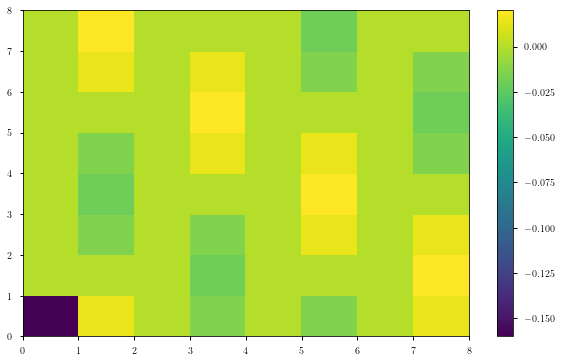

In [84]:
plt.pcolor(grad_W_accumulated)
plt.colorbar()
plt.show()

In [32]:
plt.plot(grad_W_trace[:,0,0])

-0.0032000000000000028

In [52]:
grad_W_accumulated[0,0]

-0.0015999999999999992

In [40]:
_lambda * eta * epsilon_W

0.0064

In [38]:
eta * (a_amp**2 - _lambda*a_amp**2 + 2*a_amp**2*_lambda*W_amp) * epsilon_W

-0.0016

In [237]:
eta * ((1 - _lambda)*a_amp**2 - 2*_lambda*W_amp**2) * epsilon_W

-0.00035000000000000005

In [45]:
(a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W)[0,0]

-0.6399999999999997

In [46]:
(a.reshape(N,1) @ a.reshape(1,N))[0,0]

4.0

In [47]:
(- _lambda*a.reshape(1,N)**2*W)[0,0]

-4.64

What is the constant when we integrate over one period discretely? - it's the L2 norm of the activity signal = N/2

Flipping occurs when the sum of the weight changes over the period is negative, and is greater in magnitude than the amplitude of the weight profile to start with

$$\Delta W_{mn} = \int_T a_m a_n - \lambda a_n^2 W_{mn} < -W_{mn}$$

From our derivation we know that the weight update is the following:

$$\Delta W_{mn} = \int_T a_m a_n - \lambda a_n^2 W_{mn} = \eta \|\vec p\|^2 \pi \left(\cos\left(\frac{2\pi}{N}(n-m)\right) - \lambda W_{mn}\right)$$

Because we're doing the integration as a discrete sum, we actually have the following:

$$\Delta W_{mn} = \sum_N a_m a_n - \lambda a_n^2 W_{mn} = \eta \|\vec p\|^2 \frac{N}{2} \left(\cos\left(\frac{2\pi}{N}(n-m)\right) - \lambda W_{mn}\right)$$

So we want to find out when:

$$\begin{aligned}
	\eta \|\vec p\|^2 \frac{N}{2} \left(\cos\left(\frac{2\pi}{N}(n-m)\right) - \lambda W_{mn}\right) &< -W_{mn} \\
	\eta \|\vec p\|^2 \frac{N}{2} \cos\left(\frac{2\pi}{N}(n-m)\right) &< \left(\eta \|\vec p\|^2 \frac{N}{2} \lambda - 1\right) W_{mn} \\
	W_{mn} &> \frac{\eta \|\vec p\|^2 \frac{N}{2}}{\eta \|\vec p\|^2 \frac{N}{2} \lambda - 1}\cos\left(\frac{2\pi}{N}(n-m)\right)
\end{aligned}$$

Given that we know we initialise the weights to have the right form, with a certain amplitude:

$$W_{mn} = |W|\cos\left(\frac{2\pi}{N}(n-m)\right)$$

Our condition changes to:

$$\begin{aligned}
	|W| &> \frac{\eta \|\vec p\|^2 \frac{N}{2}}{\eta \|\vec p\|^2 \frac{N}{2} \lambda - 1} \\
	&= \frac{1}{\lambda - \frac{1}{\eta \|\vec p\|^2 \frac{N}{2}}}
\end{aligned}$$

To have stable weights initially we need $\lambda = \frac{N}{2}$

$$\begin{aligned}
	|W| &> \frac{1}{\frac{N}{2} - \frac{1}{\eta \|\vec p\|^2 \frac{N}{2}}} \\
	&= \frac{\frac{2}{N}}{1 - \frac{4}{\eta \|\vec p\|^2 N^2}} \\
\end{aligned}$$

The second interesting region in the phase plot is when the weight amplitude appears to increase again - after the phase has flipped and starts to get bigger than the weight amplitude was originally. This occurs when the weight change is negative and more than twice the original weight amplitude:

$$\Delta W_{mn} = \int_T a_m a_n - \lambda a_n^2 W_{mn} < -2W_{mn}$$

Following the same derivation as above, we get:

$$|W| > \frac{\frac{2}{N}}{1 - \frac{8}{\eta \|\vec p\|^2 N^2}}$$

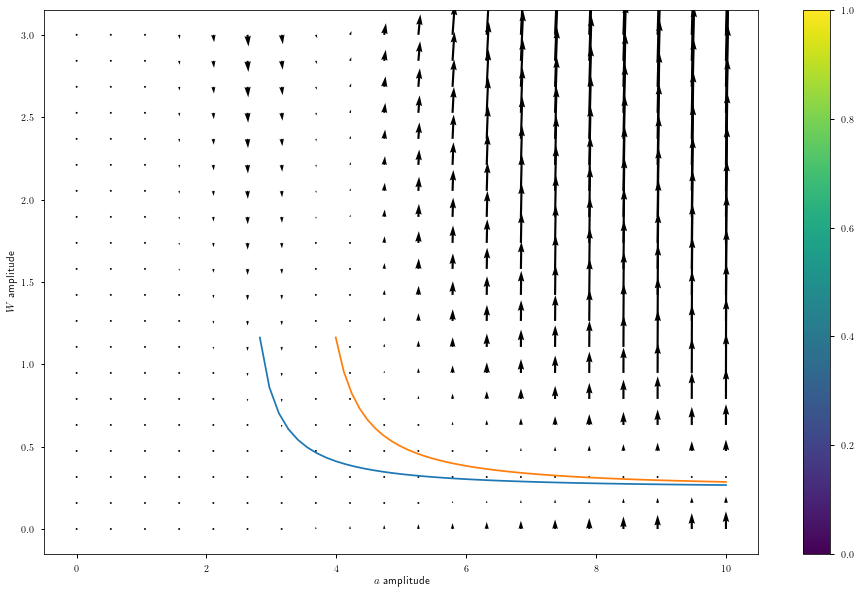

In [197]:
plt.figure(figsize=(16,10))
plt.quiver(a_amp_range, W_amp_range, a_amp_grads.T, W_amp_grads.T)
lim = plt.ylim()
# nullcline_range = a_amp_range[eta*a_amp_range**2*_lambda*np.pi > 1]
nullcline_range1 = np.linspace(np.sqrt(1/eta/np.pi/_lambda)+0.001, a_amp_range[-1], 50)
nullcline_range2 = np.linspace(np.sqrt(2/eta/np.pi/_lambda)+0.001, a_amp_range[-1], 50)
plt.plot(nullcline_range1, 2/N / (1 - 4/(eta*nullcline_range1**2*N**2)))
plt.plot(nullcline_range2, 2/N / (1 - 8/(eta*nullcline_range2**2*N**2)))
plt.ylim(lim)
plt.xlabel('$a$ amplitude')
plt.ylabel('$W$ amplitude')
plt.colorbar()
plt.show()

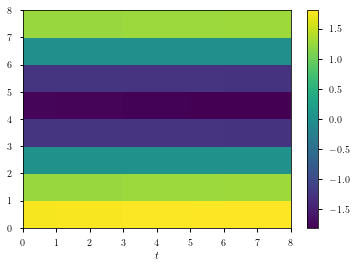

In [96]:
def trace_over_period_dynamic(W, a0, _lambda, eta):
	W_list = []
	a_list = []
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	for t in range(W.shape[0]):
		grad_W = a.reshape(N,1) @ a.reshape(1,N) -  _lambda*a.reshape(N,1)**2*W
		grad_a = W@a - a
		a += eta*grad_a
		W += eta*grad_W
		grad_W_accumulated += grad_W
		a_list.append(a.copy())
		W_list.append(W + grad_W_accumulated)
	return np.array(a_list), np.array(W_list)

def get_trace_over_period_dynamic(a_amp, W_amp, f=1, eta=0.001, _lambda=5.0):
	W = profile_to_matrix(W_amp*np.cos(2*f*np.pi*neuron_indices/N))
	a0 = a_amp*np.cos(2*f*np.pi*neuron_indices/N)
	return trace_over_period_dynamic(W, a0, _lambda, eta)

a_trace, W_trace = get_trace_over_period_dynamic(1.75, 1.1907, _lambda=1, f=1)
plt.pcolor(a_trace.T)
plt.xlabel('$t$')
plt.colorbar()
plt.show()

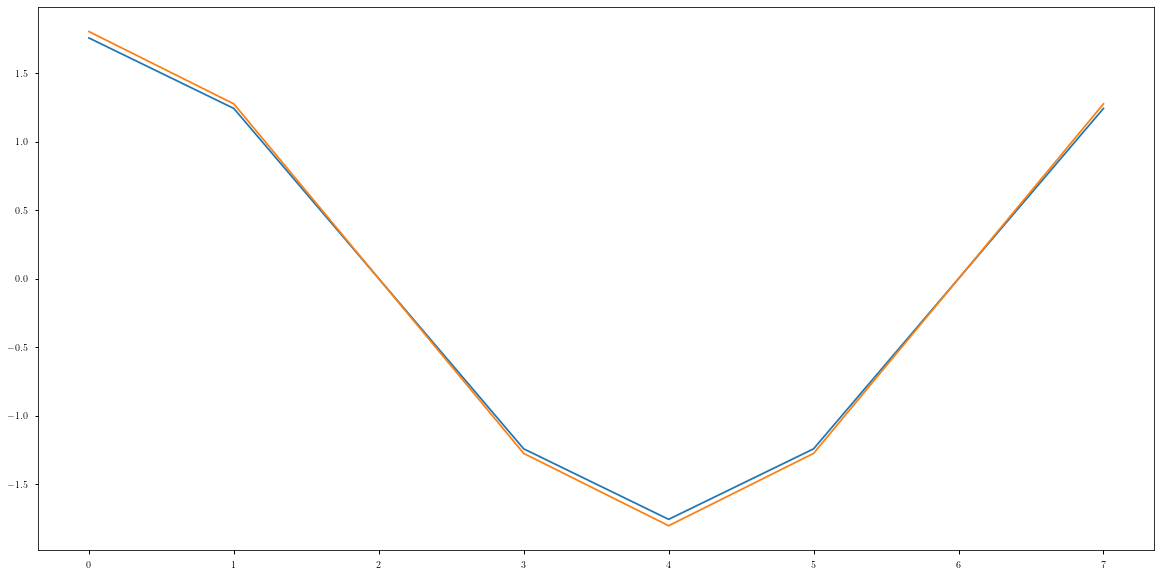

In [106]:
plt.figure(figsize=(20,10))
plt.plot(a_trace[0])
plt.plot(a_trace[-1])

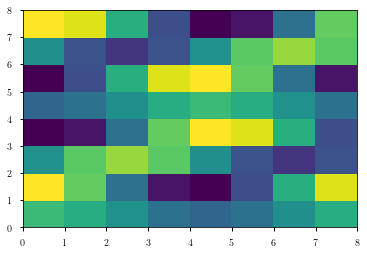

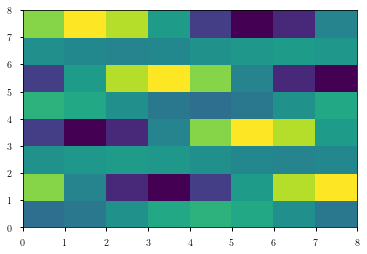

In [108]:
plt.pcolor(W_trace[0])
plt.show()
plt.pcolor(W_trace[-1])

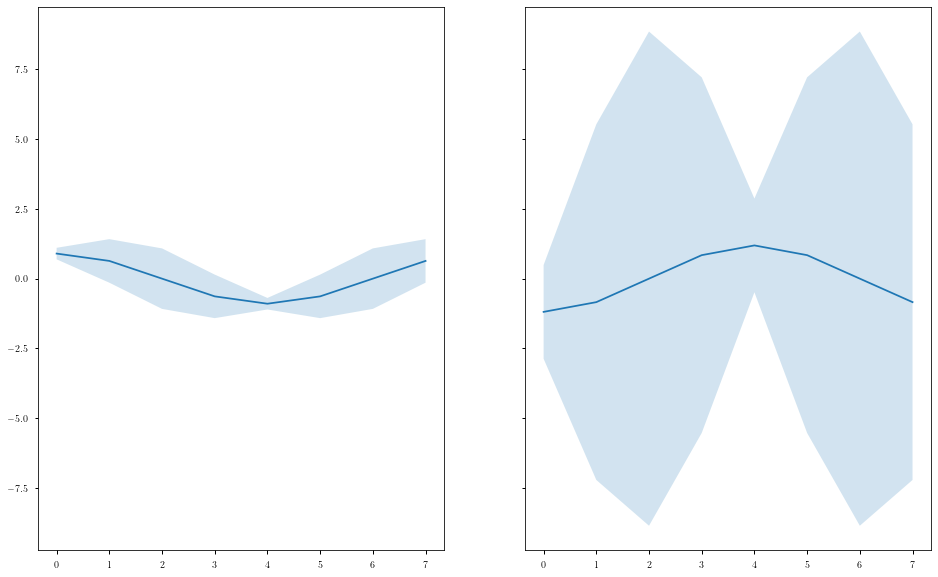

In [113]:
fig, axs = plt.subplots(1,2,figsize=(16,10), sharey=True)
plt.sca(axs[0])
plot_circulant_matrix_as_profile(W_trace[0], show=False)
plt.sca(axs[1])
plot_circulant_matrix_as_profile(W_trace[-1])

### Plotting the results

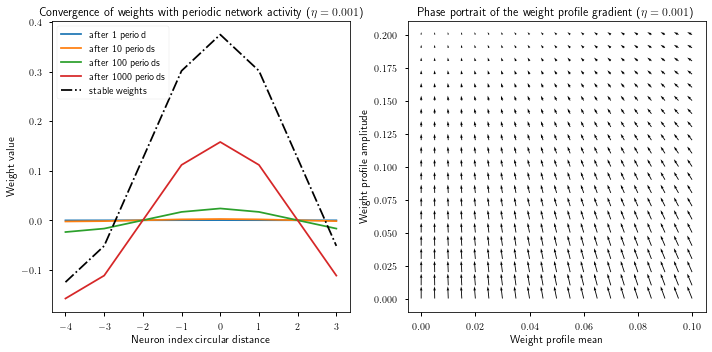

In [10]:
W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (1000,1)), plot=False, _lambda=_lambda, eta=0.001)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.sca(axs[0])
plot_circulant_matrix_as_profile(np.array(W_trace)[N*1-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(np.array(W_trace)[N*10-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(np.array(W_trace)[N*100-1,:,:], plot_stddev=False, roll=True, show=False)
plot_circulant_matrix_as_profile(np.array(W_trace)[N*1000-1,:,:], plot_stddev=False, roll=True, show=False)
axs[0].plot(neuron_indices-N//2, np.roll(get_cosine_from_fourier_modes([1,1] + [0]*(N//2+1-2)), N//2), 'k-.')
axs[0].legend(['after 1 period','after 10 periods','after 100 periods','after 1000 periods','stable weights'])
# handles, labels = axs[0].get_legend_handles_labels()
# axs[0].legend(handles[::-1], labels[::-1])
plt.title('Convergence of weights with periodic network activity ($\\eta=0.001$)')
plt.ylabel('Weight value')
plt.xlabel('Neuron index circular distance')
plt.sca(axs[1])
# plt.pcolor(W)
# plt.colorbar()
# plt.tight_layout()
plt.quiver(mu, amp, mu_grad_one.T, amp_grad_one.T)
plt.xlabel('Weight profile mean')
plt.ylabel('Weight profile amplitude')
plt.title('Phase portrait of the weight profile gradient ($\\eta=0.001$)')
plt.tight_layout()
# plt.savefig('plots/hebbian-learning-fixed-activity.pdf')
plt.show()

## What if the activity in the network is also dynamic?

In [54]:
def simulate_and_plot_input(input, eta=0.001, _lambda=5, plot=True, show=True):
	a_trace = []
	W_trace = []
	delta_a_trace = []
	delta_W_trace = []

	accumulated_delta_W = 0

	N = input.shape[1]
	# a = np.zeros(N)
	a = np.random.randn(N)
	# a = (np.cos(2*np.pi*neuron_indices/N))
	# W = np.zeros((N,N))
	W = .5*profile_to_matrix(get_cosine_from_fourier_modes([0,1] + [0]*(N//2+1-2)))
	for t in range(input.shape[0]):
		delta_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(N,1)**2*W
		delta_a = W@a - a + input[t,:]
		accumulated_delta_W += delta_W
		if t-1 % N == 0:
			W += eta*delta_W
			accumulated_delta_W = 0
		# W += eta*delta_W
		a += eta*delta_a
		a_trace.append(a.copy())
		W_trace.append(W.copy())
		delta_a_trace.append(delta_a.copy())
		delta_W_trace.append(delta_W.copy())

	if plot:
		plt.imshow(W)
		plt.colorbar()
		if show:
			plt.show()
		plt.figure()
		# plt.plot(input[-1,:], label='last input')
		plt.plot(a, label='activity')
		plt.legend()
		if show:
			plt.show()
		plt.figure()
		plot_circulant_matrix_as_profile(W, show=show)
	return a_trace, W_trace, delta_a_trace, delta_W_trace

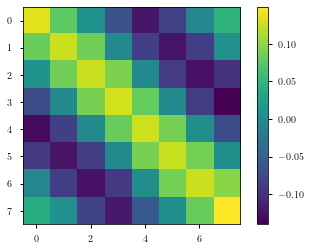

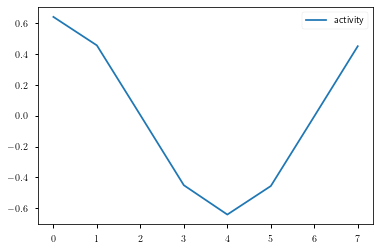

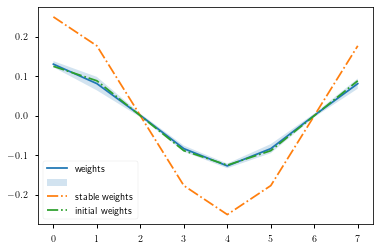

In [55]:
slow_input = roll_matrix_rows(np.tile(a-a.mean(), (4*N,1)), np.arange(4*N)//4)

better_input = 20*2.4504285082390176*profile_to_matrix(np.sin(2*np.pi*neuron_indices/N - np.pi/N)).T

# simulate_and_plot_input(slow_input)
a_trace, W_trace, delta_a_trace, delta_W_trace = simulate_and_plot_input(np.tile(better_input,(1000,1)), eta=0.01, show=False, _lambda=_lambda)
# plt.plot((a.max()/2)**2 * 1/2 / l * (2 + np.cos(2*np.pi/N*neuron_indices)))
plt.plot(get_cosine_from_fourier_modes([0,1] + [0]*(N//2+1-2)), '-.')
plt.plot(get_circulant_matrix_profile(W_trace[0])[0], '-.')
plt.legend(['weights',None,'stable weights','initial weights'])

In [13]:
np.linalg.eigvals(W_trace[-1])

array([ 0.00000000e+00+0.00000000e+00j,  8.96268099e-03+0.00000000e+00j,
        3.92356971e-19+0.00000000e+00j, -2.94619794e-19+0.00000000e+00j,
        5.39124717e-20+2.33275832e-20j,  5.39124717e-20-2.33275832e-20j,
       -8.07541048e-20+0.00000000e+00j, -1.53224639e-19+0.00000000e+00j])

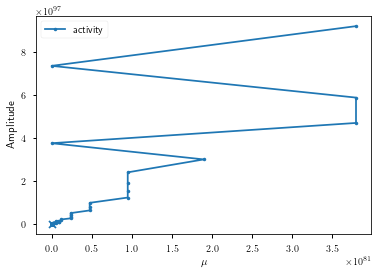

In [28]:
spacing = 8
# mus_W, amps_W = np.array([profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])[:2] for W in W_trace[::spacing]]).T
mus_a, amps_a = np.array([profile_to_mu_amp_phase(a)[:2] for a in a_trace[::spacing]]).T
# plt.plot(mus_W, amps_W, label='weights')
plt.plot(mus_a, amps_a, '.-', label='activity')
# plt.scatter(mus_W[0], amps_W[0], marker='x')
plt.scatter(mus_a[0], amps_a[0], marker='x')
plt.xlabel('$\\mu$')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

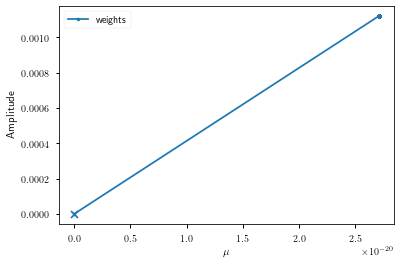

In [15]:
mus_W, amps_W = np.array([profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])[:2] for W in W_trace[::spacing]]).T
plt.plot(mus_W, amps_W, '.-', label='weights')
plt.scatter(mus_W[0], amps_W[0], marker='x')
plt.xlabel('$\\mu$')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

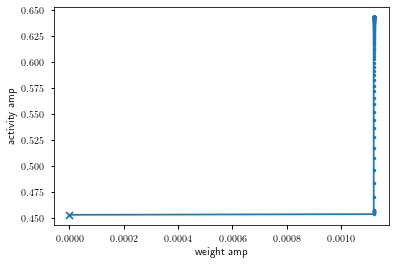

In [16]:
plt.plot(amps_W, amps_a, '.-')
plt.scatter(amps_W[0], amps_a[0], marker='x')
plt.xlabel('weight amp')
plt.ylabel('activity amp')
plt.show()

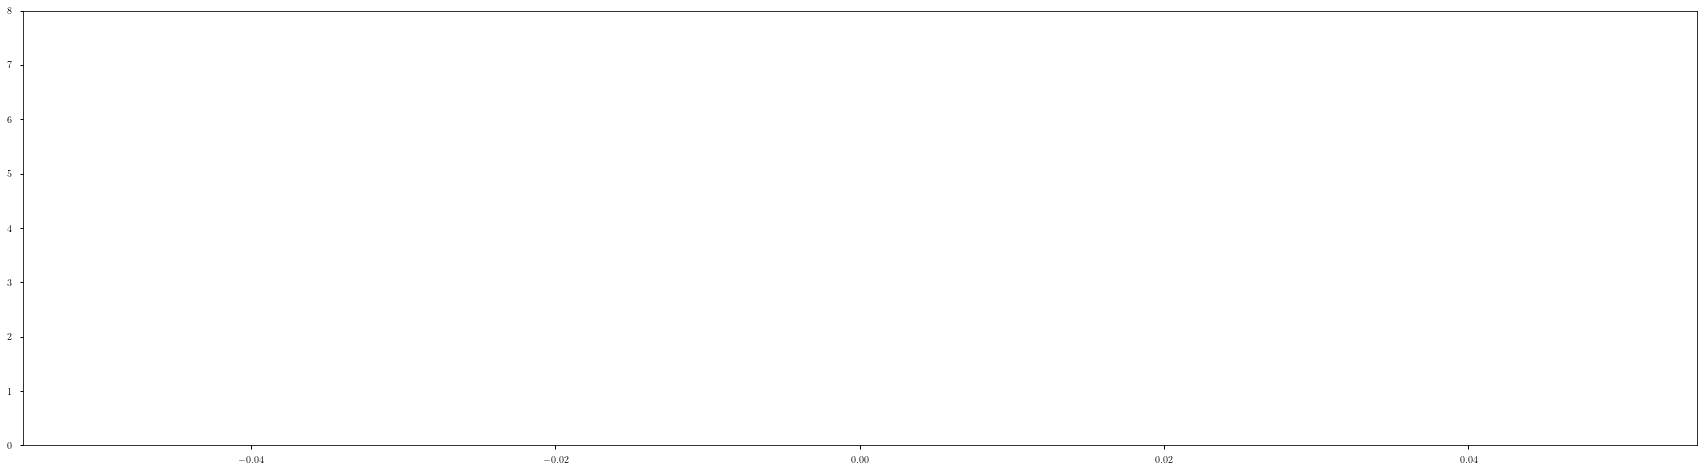

In [17]:
plt.figure(figsize=(30,8))
plt.pcolor(np.array(a_trace).T[:,10000:-2000])

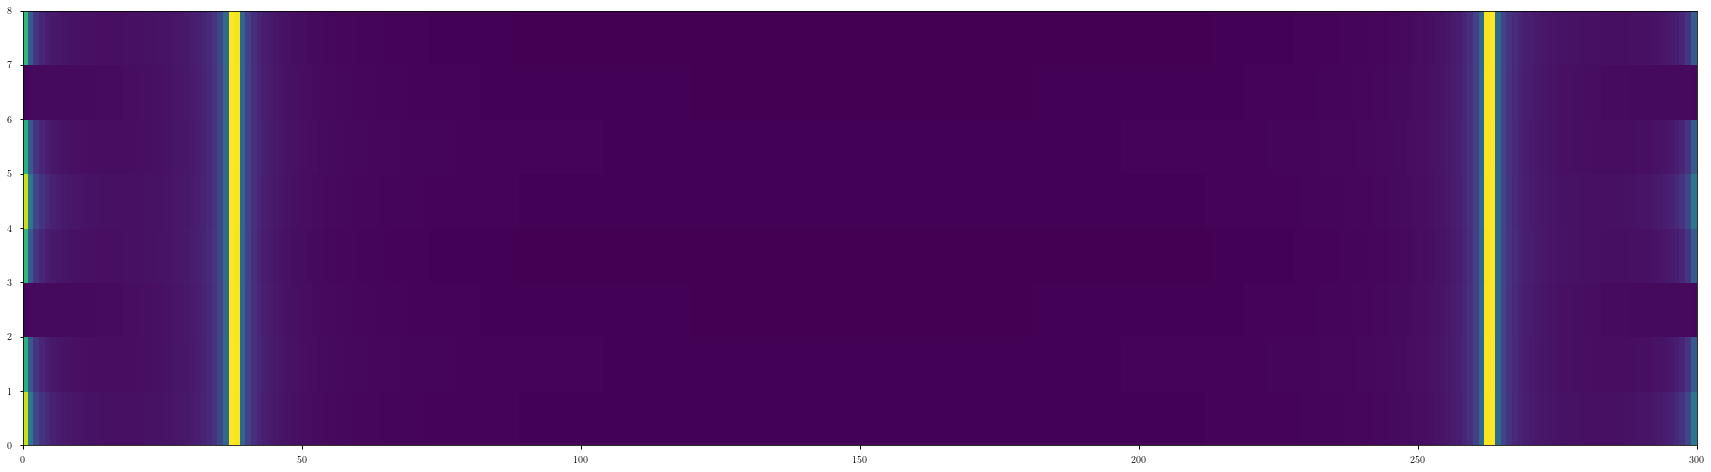

In [18]:
plt.figure(figsize=(30,8))
plt.pcolor(abs(np.fft.fft(np.array(a_trace).T[:,:300], axis=1)))

In [19]:
abs(np.fft.fft(np.array(a_trace).T[:,100:102], axis=1)[:N//2+1])

array([[0.86997273, 0.45943368],
       [1.39892432, 0.19550936],
       [1.10840502, 0.18294169],
       [0.16859709, 0.45422798],
       [0.86997273, 0.45943368]])

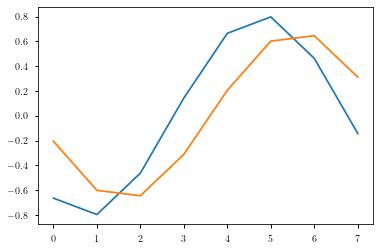

In [20]:
plt.plot(np.array(a_trace).T[:,100:102])

c:\ProgramData\Miniconda3\envs\insects\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


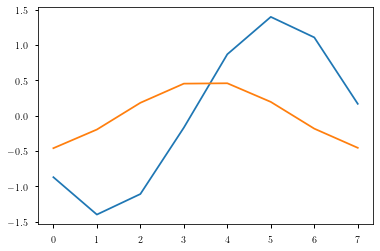

In [21]:
plt.plot(np.fft.fft(np.array(a_trace).T[:,100:102], axis=1))